In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
import math
import datetime
import missingno as msno
from scipy.stats import norm, skew
from sklearn import metrics
from collections import Counter
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

from termcolor import colored
import warnings
warnings.filterwarnings("ignore")
from sklearn import set_config
set_config(print_changed_only = False)
pd.set_option('display.max_columns', 15)

In [3]:
car = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Vehicle%20dataset/Car%20details%20v3.csv")
df = car.copy()
df.head().style.background_gradient(cmap = "autumn")

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.000000
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.000000
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.000000
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.000000
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.000000


In [4]:
print("The number of rows in train data is {0}, and the number of columns in train data is {1}".
      format(df.shape[0], df.shape[1]))

The number of rows in train data is 8128, and the number of columns in train data is 13


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [6]:
categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")

df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")

df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")

df["car_age"] = (datetime.datetime.now().year) - (df["year"])
df.drop(["name", "year", "torque"], axis = 1, inplace = True)
df.head().style.background_gradient(cmap = "summer")

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.400000,1248.000000,74.000000,5.000000,Maruti,8
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.140000,1498.000000,103.520000,5.000000,Skoda,8
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.700000,1497.000000,78.000000,5.000000,Honda,16
3,225000,127000,Diesel,Individual,Manual,First Owner,23.000000,1396.000000,90.000000,5.000000,Hyundai,12
4,130000,120000,Petrol,Individual,Manual,First Owner,16.100000,1298.000000,88.200000,5.000000,Maruti,15


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


In [8]:
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [9]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
selling_price,8128.000000,638271.807702,806253.403508,29999.000000,254999.000000,450000.000000,675000.000000,10000000.000000
km_driven,8128.000000,69819.510827,56550.554958,1.000000,35000.000000,60000.000000,98000.000000,2360457.000000
mileage,7907.000000,19.418783,4.037145,0.000000,16.780000,19.300000,22.320000,42.000000
engine,7907.000000,1458.625016,503.916303,624.000000,1197.000000,1248.000000,1582.000000,3604.000000
max_power,7912.000000,91.517919,35.822499,0.000000,68.050000,82.000000,102.000000,400.000000
seats,7907.000000,5.416719,0.959588,2.000000,5.000000,5.000000,5.000000,14.000000
car_age,8128.000000,8.195989,4.044249,2.000000,5.000000,7.000000,11.000000,39.000000


In [10]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
selling_price,8128.000000,638271.807702,806253.403508,29999.000000,254999.000000,450000.000000,675000.000000,10000000.000000
km_driven,8128.000000,69819.510827,56550.554958,1.000000,35000.000000,60000.000000,98000.000000,2360457.000000
mileage,7907.000000,19.418783,4.037145,0.000000,16.780000,19.300000,22.320000,42.000000
engine,7907.000000,1458.625016,503.916303,624.000000,1197.000000,1248.000000,1582.000000,3604.000000
max_power,7912.000000,91.517919,35.822499,0.000000,68.050000,82.000000,102.000000,400.000000
seats,7907.000000,5.416719,0.959588,2.000000,5.000000,5.000000,5.000000,14.000000
car_age,8128.000000,8.195989,4.044249,2.000000,5.000000,7.000000,11.000000,39.000000


In [11]:
df.describe(include = "category").T

,count,unique,top,freq
fuel,8128,4,Diesel,4402
seller_type,8128,3,Individual,6766
transmission,8128,2,Manual,7078
owner,8128,5,First Owner,5289
car_brand_name,8128,32,Maruti,2448


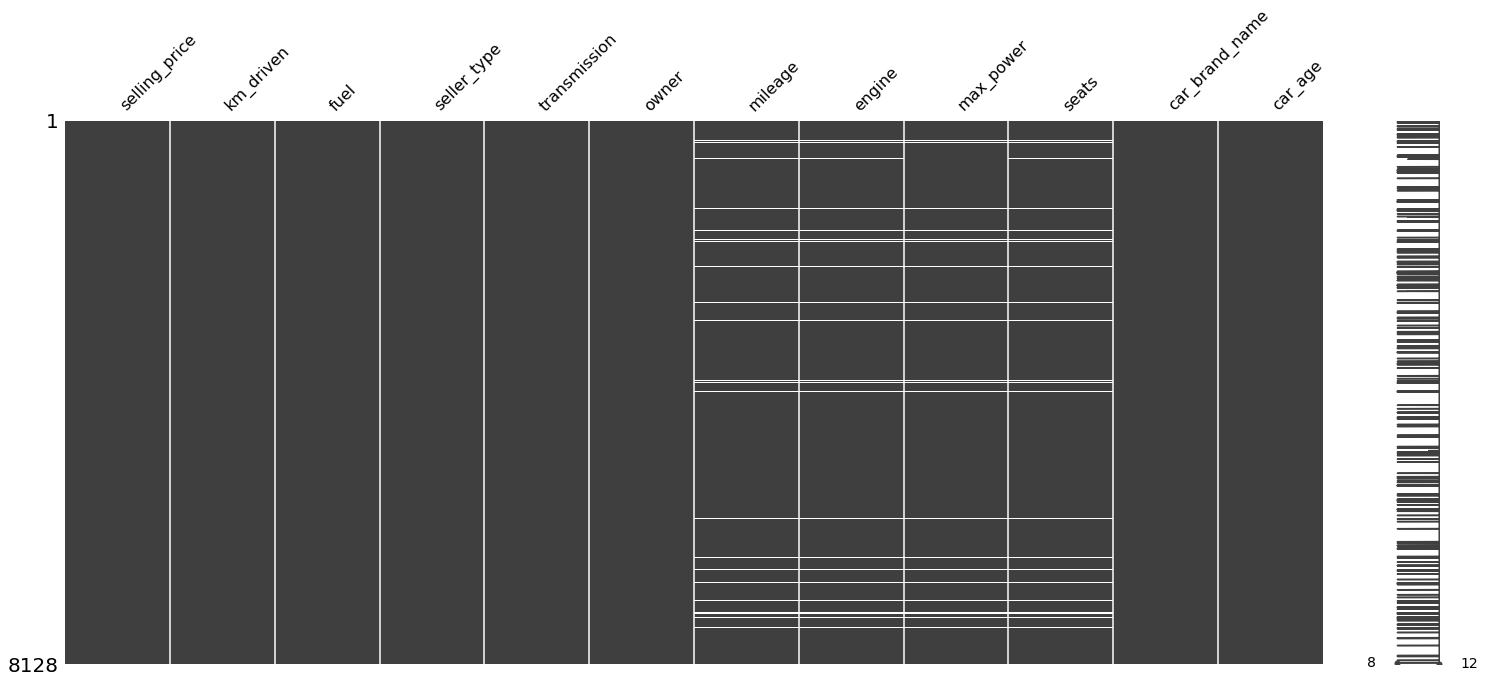

In [12]:
msno.matrix(df);

<Figure size 720x360 with 0 Axes>

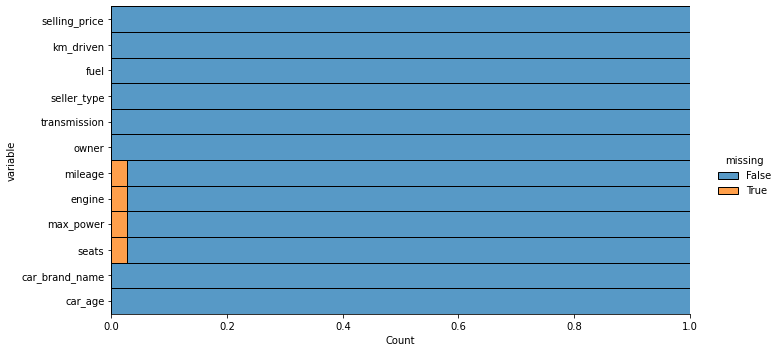

In [13]:
plt.figure(figsize = (10, 5))
sns.displot(
    data = df.isna().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 2
);

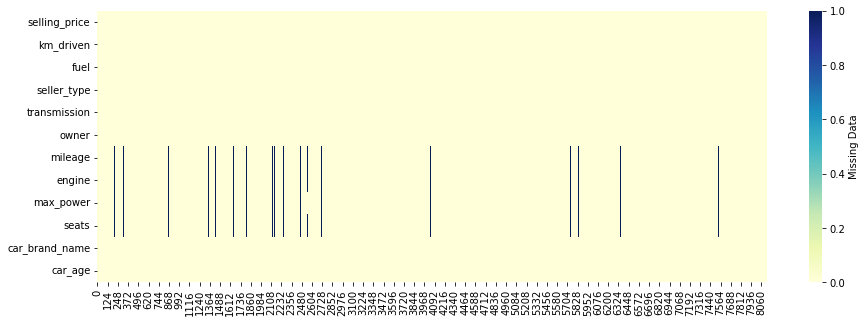

In [14]:
plt.figure(figsize = (15, 5))
sns.heatmap(df.isna().transpose(),
            cmap = "YlGnBu",
            cbar_kws = {'label': 'Missing Data'});


numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [16]:
df.isnull().sum().sum()

0

In [17]:
print("Class frequencies of 'transmission' variable: \n\n", df["transmission"].value_counts())

print("_____________________________________________________________________________________")

print("Class frequencies of 'seller_type' variable: \n\n", df["seller_type"].value_counts())

print("_____________________________________________________________________________________")

print("Class frequencies of 'owner' variable: \n\n", df["owner"].value_counts())

print("_____________________________________________________________________________________")

print("Class frequencies of 'car_brand_name' variable: \n\n", df["car_brand_name"].value_counts())

Class frequencies of 'transmission' variable: 

 Manual       7078
Automatic    1050
Name: transmission, dtype: int64
_____________________________________________________________________________________
Class frequencies of 'seller_type' variable: 

 Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64
_____________________________________________________________________________________
Class frequencies of 'owner' variable: 

 First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64
_____________________________________________________________________________________
Class frequencies of 'car_brand_name' variable: 

 Maruti           2448
Hyundai          1415
Mahindra          772
Tata              734
Toyota            488
Honda             467
Ford              397
Chevrolet         230
Renault           228
Volkswa

In [18]:
df.corr().style.background_gradient(cmap = "copper")

,selling_price,km_driven,mileage,engine,max_power,seats,car_age
selling_price,1.000000,-0.225534,-0.125040,0.458345,0.747935,0.047135,-0.414092
km_driven,-0.225534,1.000000,-0.171746,0.198911,-0.040599,0.219860,0.418006
mileage,-0.125040,-0.171746,1.000000,-0.574128,-0.372897,-0.450578,-0.311657
engine,0.458345,0.198911,-0.574128,1.000000,0.703612,0.612220,-0.035851
max_power,0.747935,-0.040599,-0.372897,0.703612,1.000000,0.194556,-0.224704
seats,0.047135,0.219860,-0.450578,0.612220,0.194556,1.000000,-0.010222
car_age,-0.414092,0.418006,-0.311657,-0.035851,-0.224704,-0.010222,1.000000


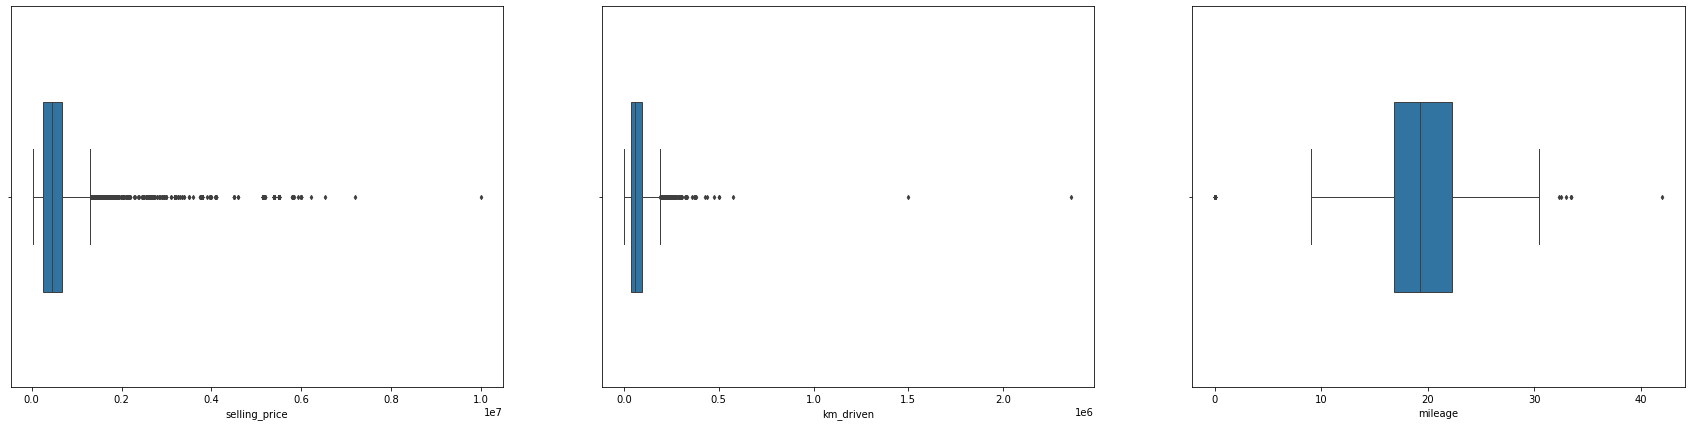

In [19]:
fig, axes = plt.subplots(1, 3, figsize = (30, 7))

sns.boxplot(ax = axes[0], x = "selling_price", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "km_driven", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "mileage", data = df, width = 0.5, fliersize = 3, linewidth = 1);

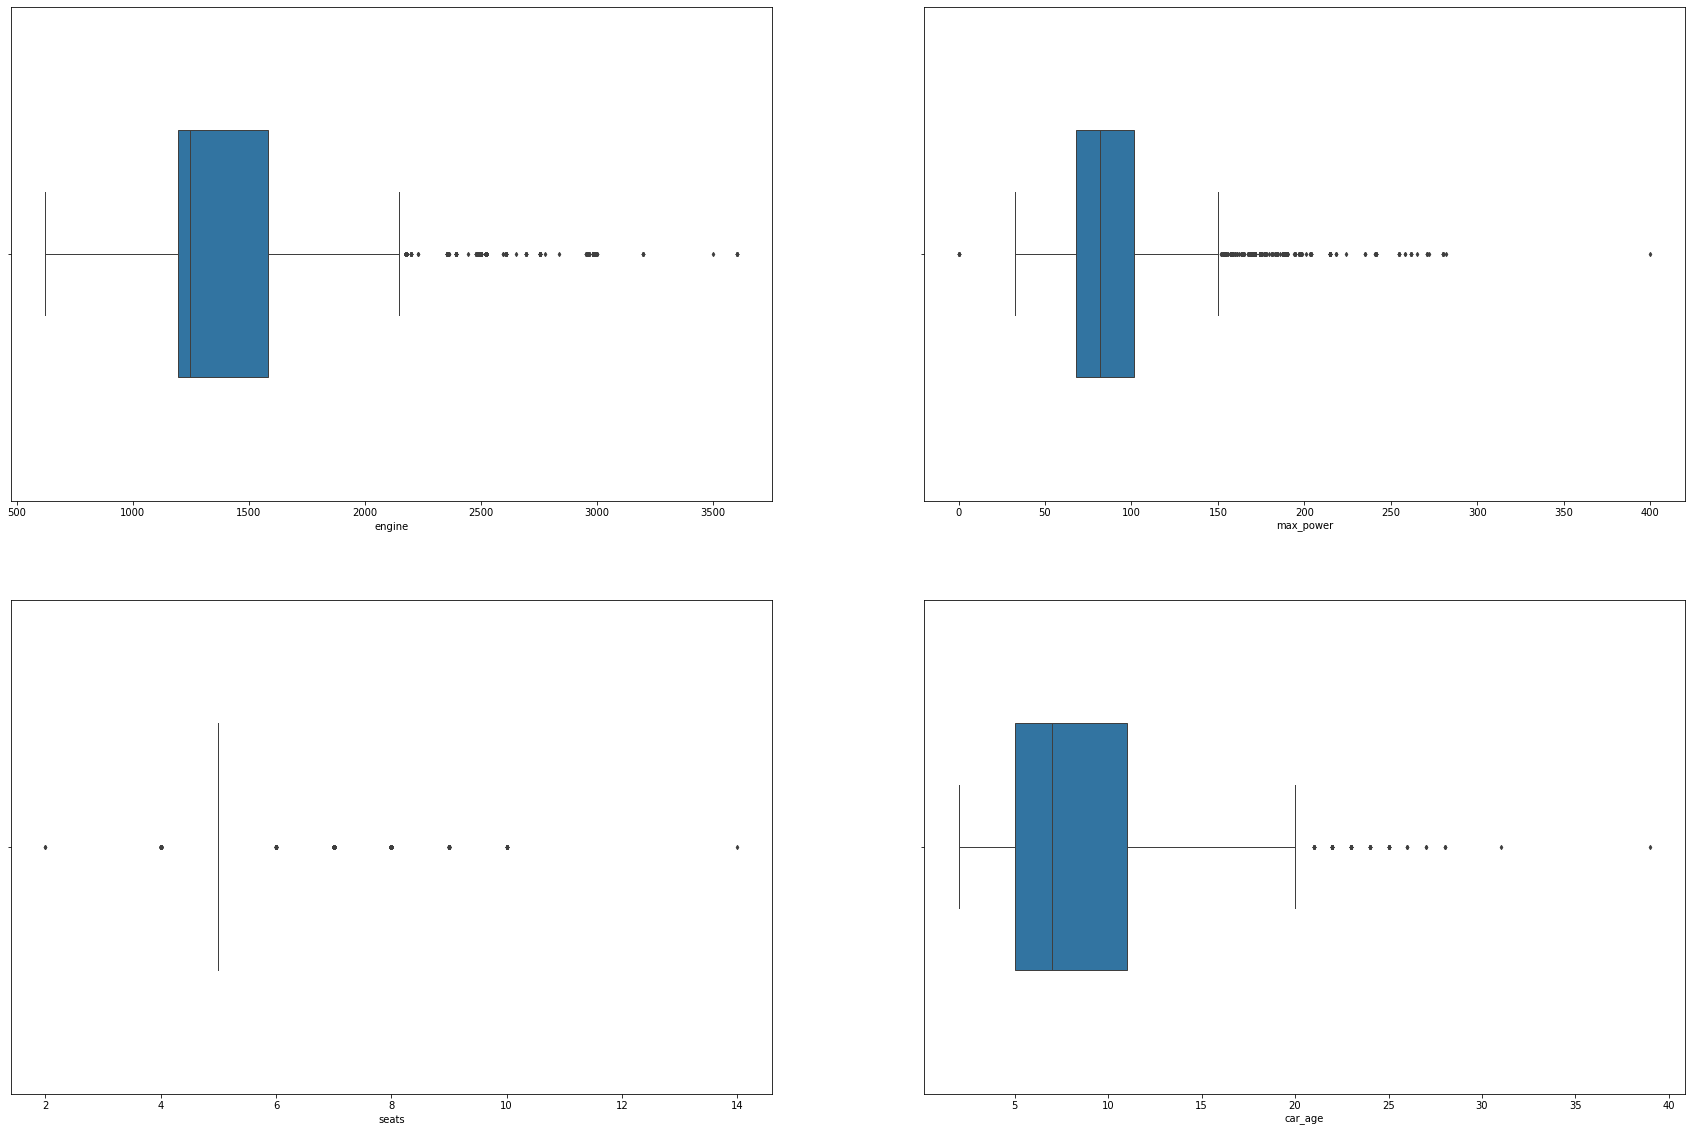

In [20]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20))
axes = axes.flatten()

sns.boxplot(ax = axes[0], x = "engine", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "max_power", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "seats", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[3], x = "car_age", data = df, width = 0.5, fliersize = 3, linewidth = 1);

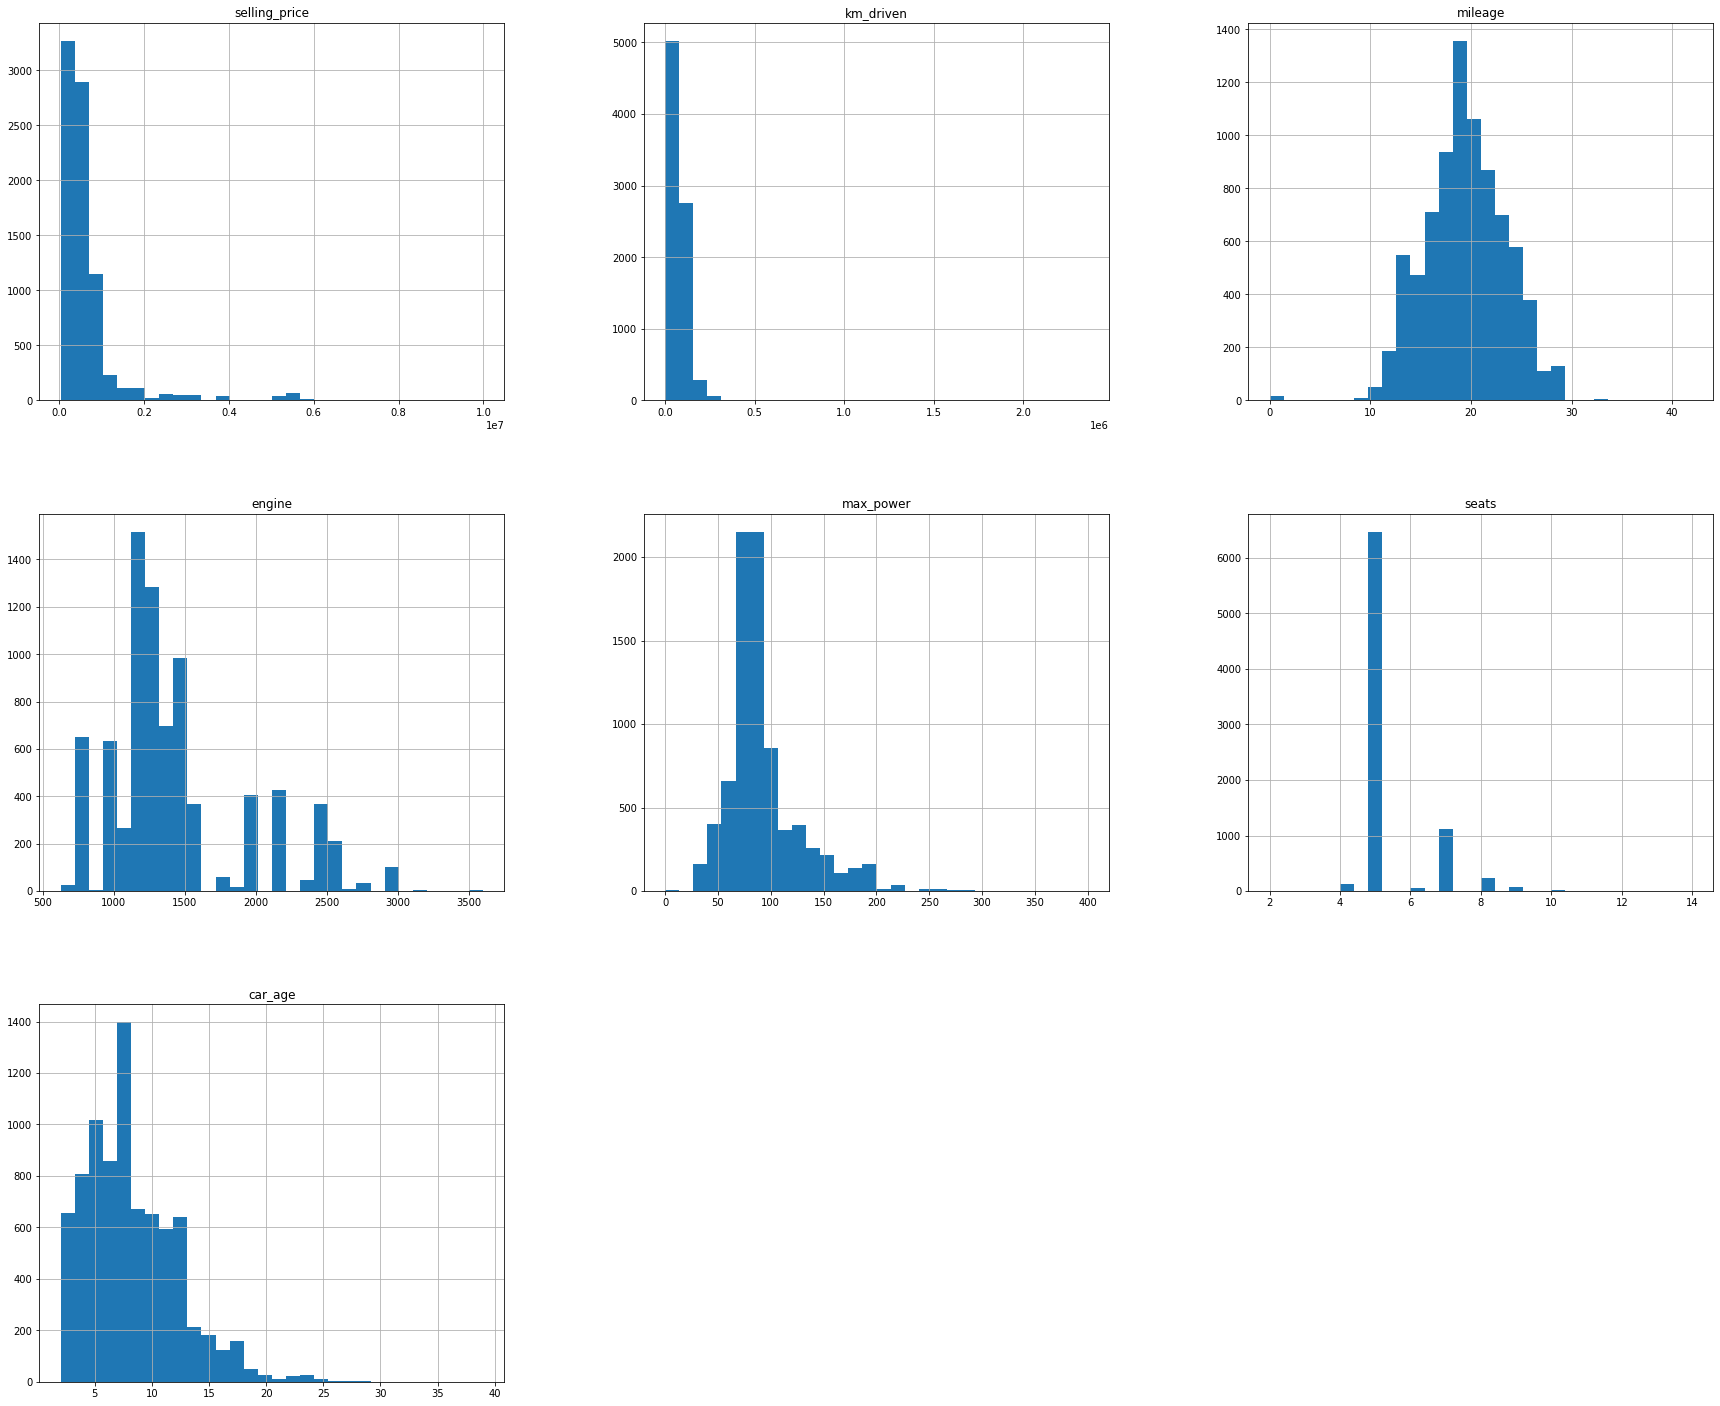

In [21]:
df.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

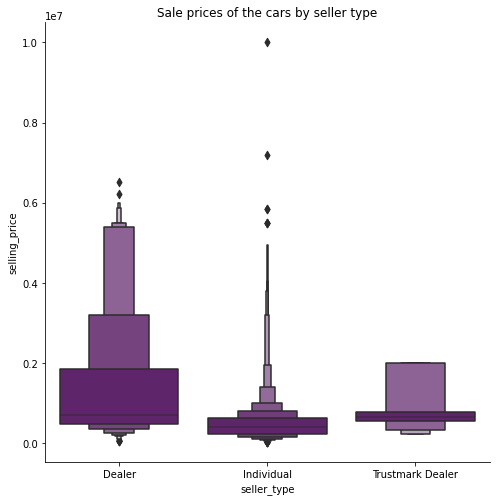

In [22]:
sns.catplot(x = "seller_type",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1,
            color = "#671A76",
            data = df).set(title = "Sale prices of the cars by seller type");

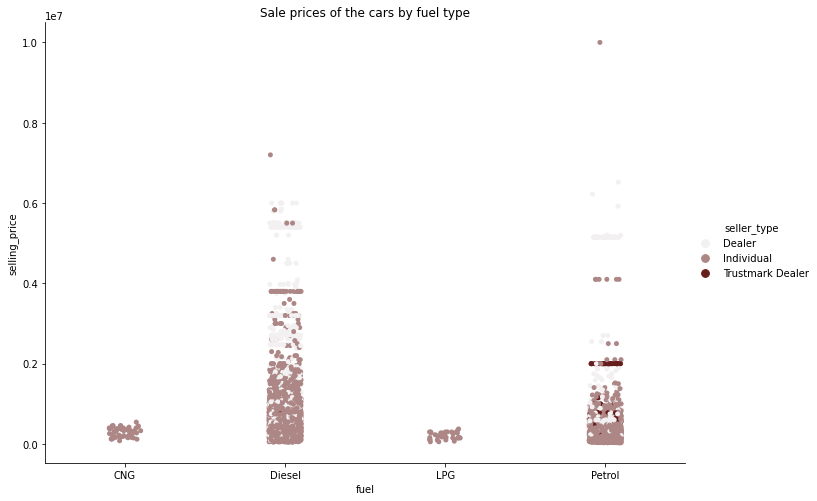

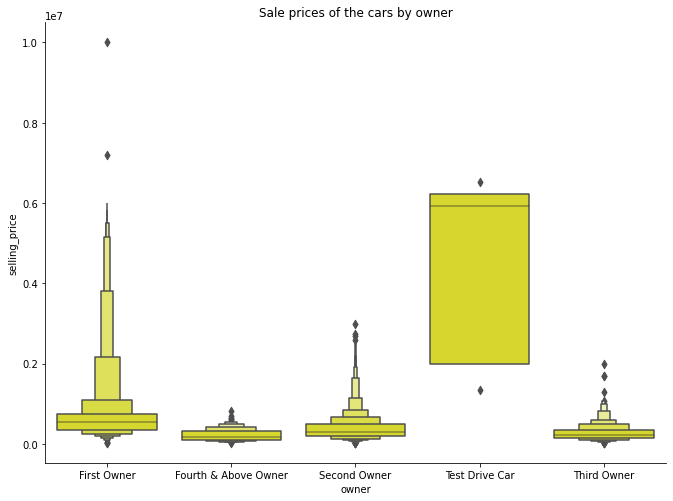

In [23]:
sns.catplot(x = "fuel",
            y = "selling_price",
            kind = "strip",
            hue = "seller_type",
            height = 7,
            aspect = 1.4,
            color = "#661E1D",
            data = df).set(title = "Sale prices of the cars by fuel type");

sns.catplot(x = "owner",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1.35,
            color = "#F0F312",
            data = df).set(title = "Sale prices of the cars by owner");

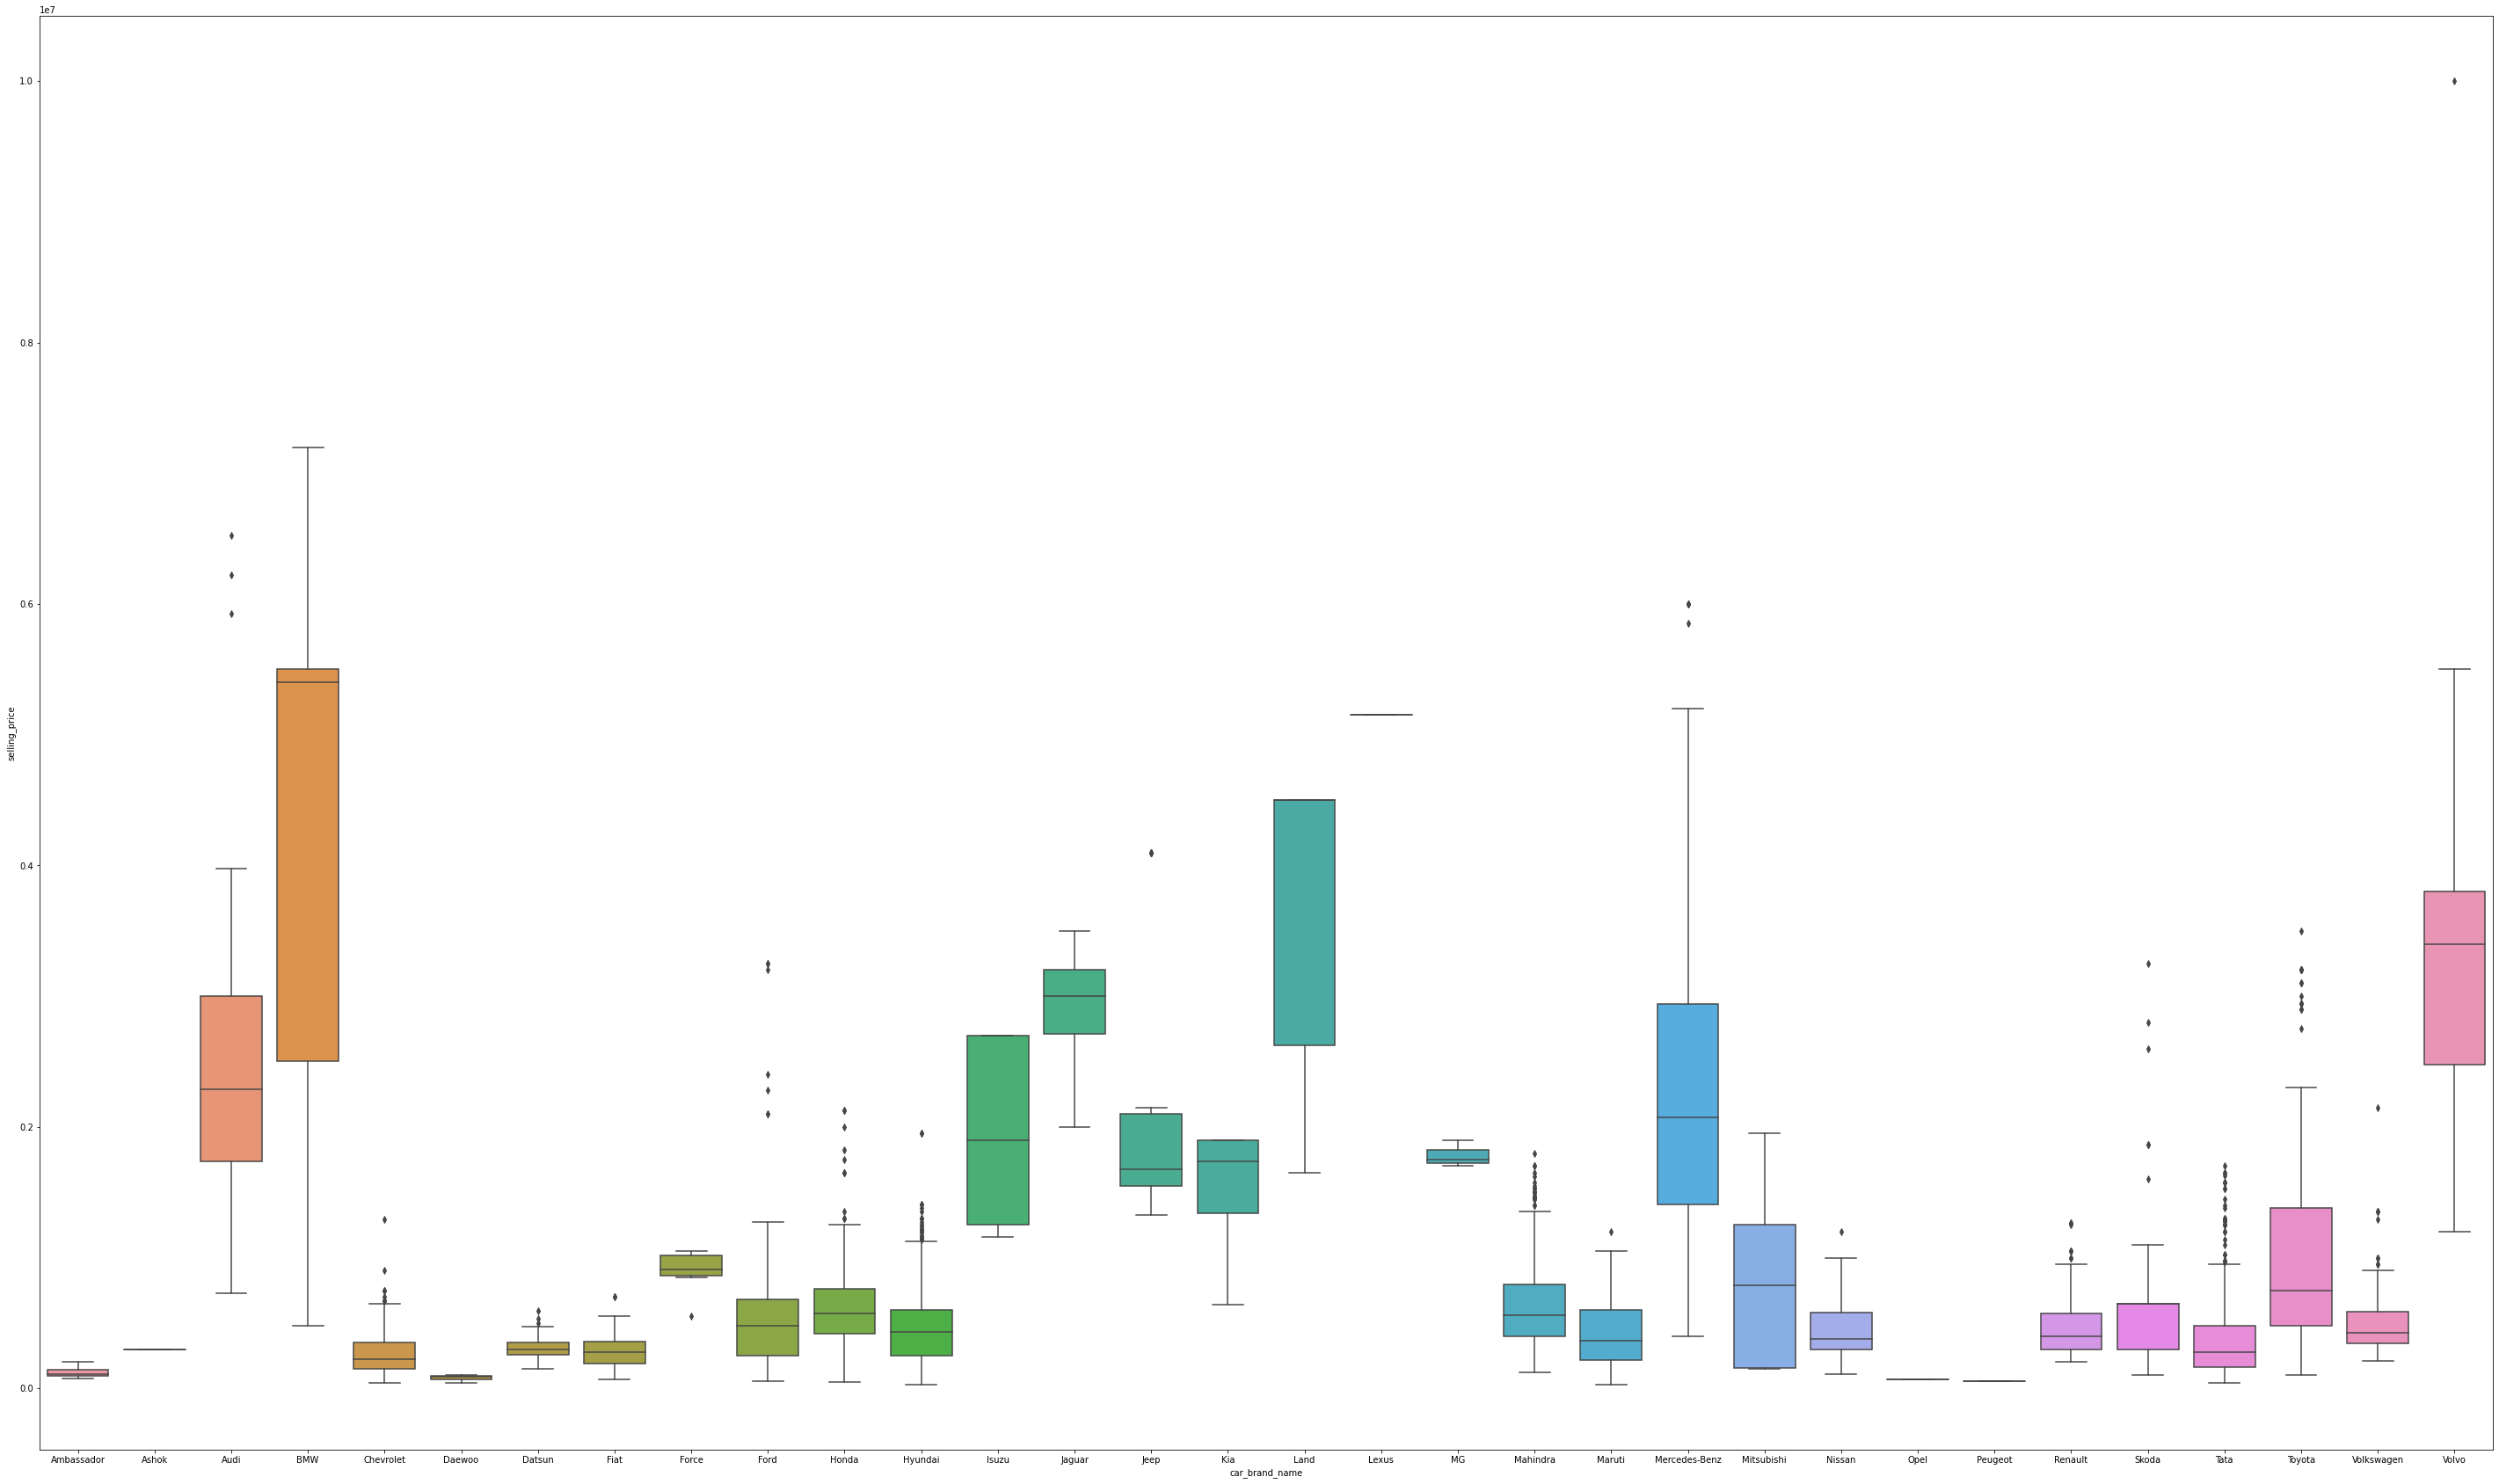

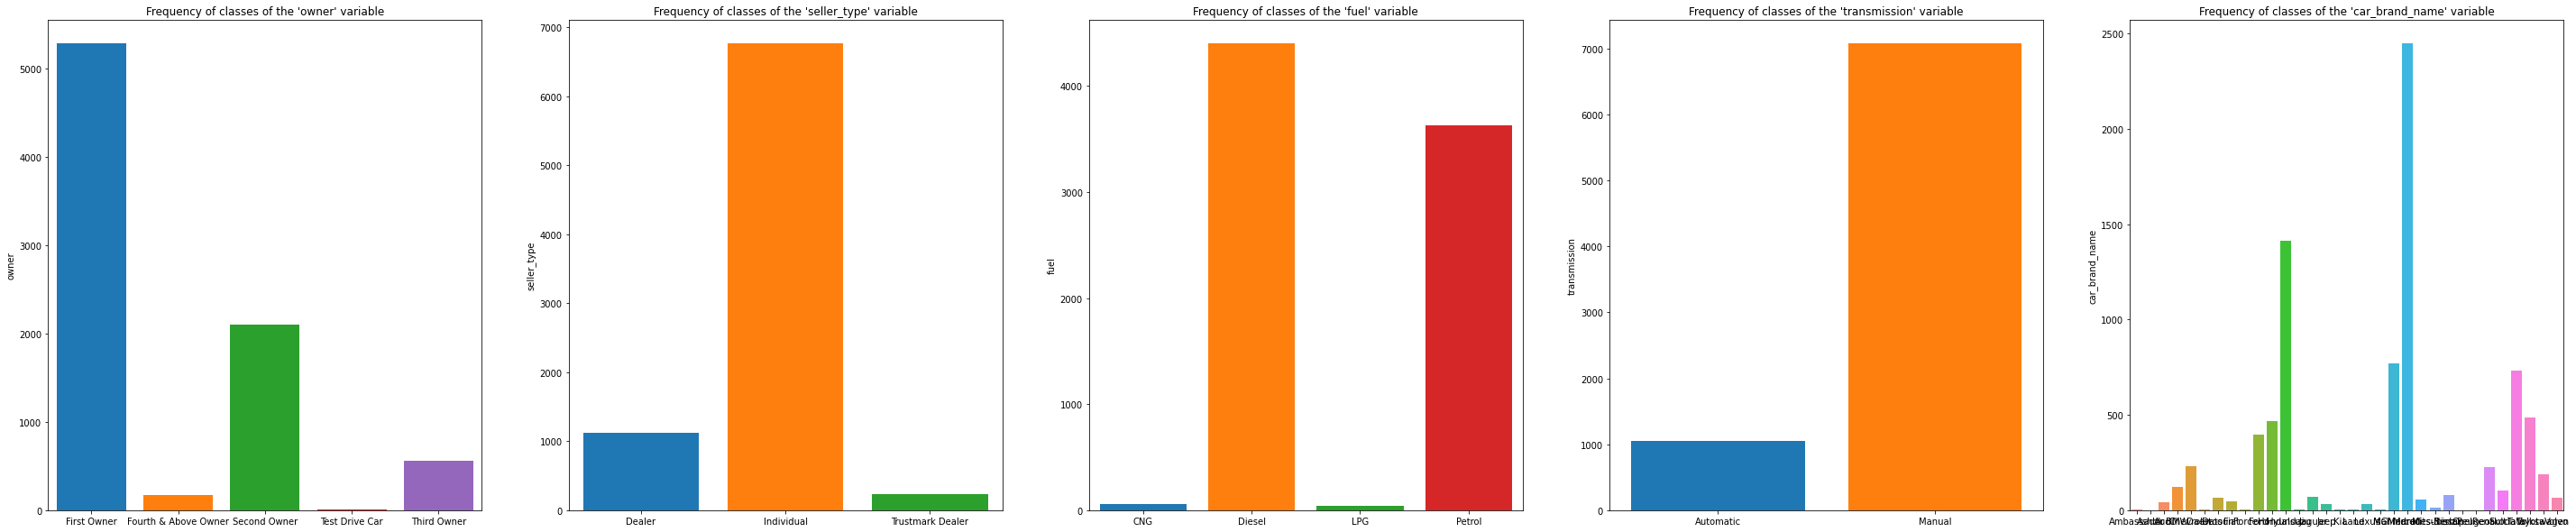

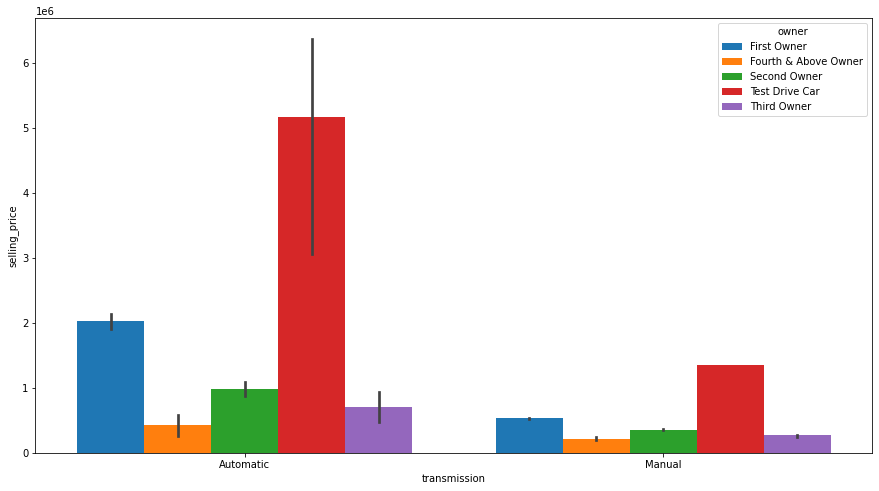

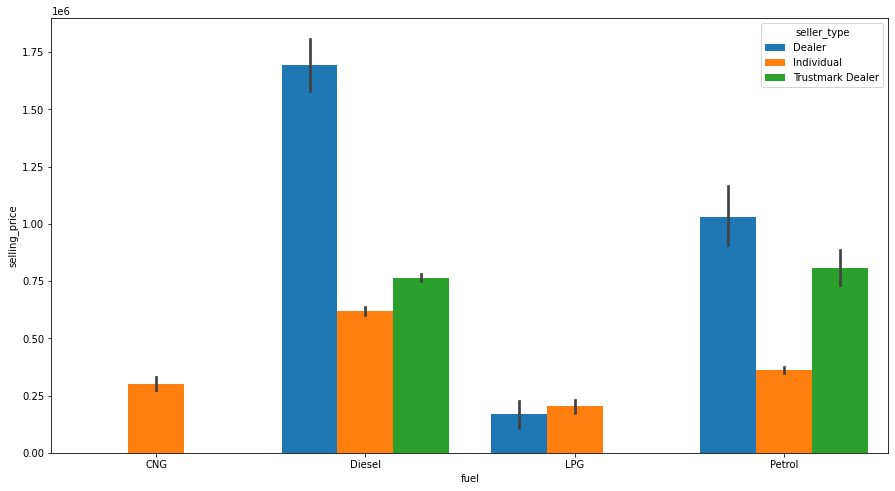

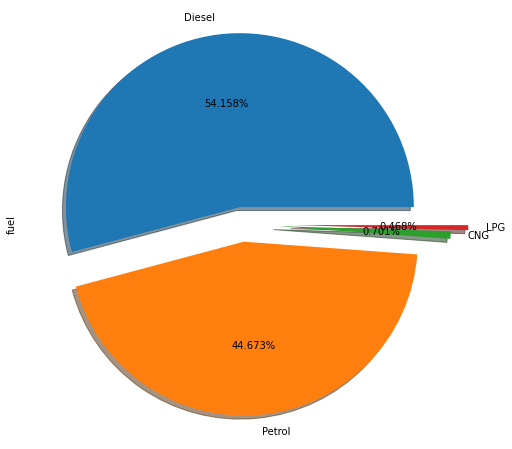

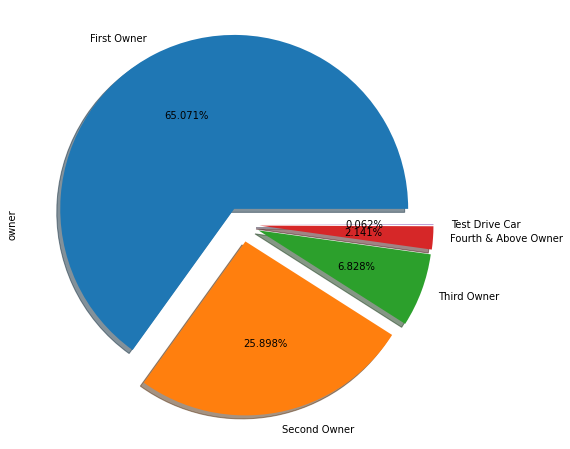

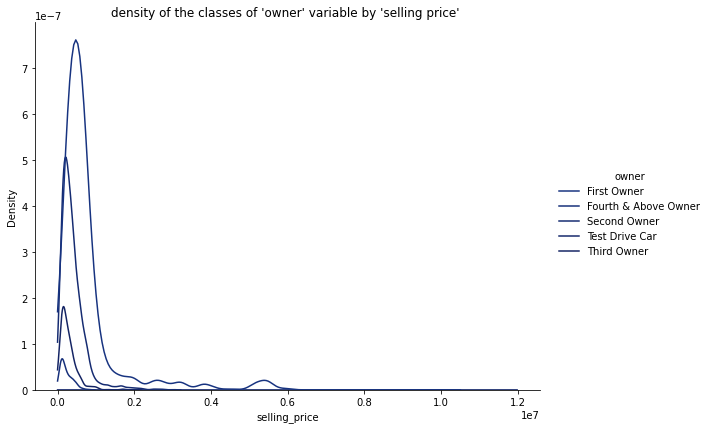

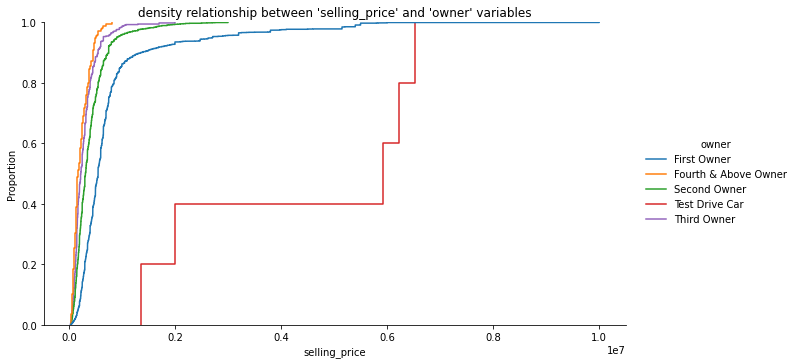

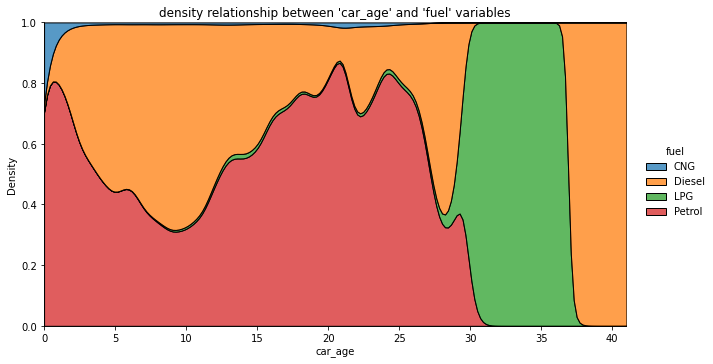

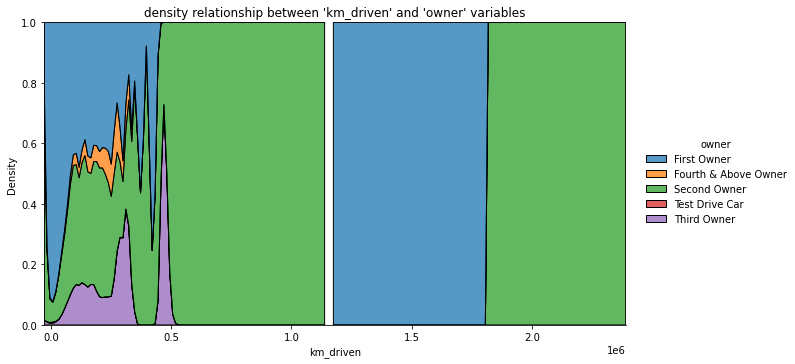

In [24]:
price = df["selling_price"]
brand = df["car_brand_name"]
dff = pd.concat([price, brand], axis = 1)      
f, ax = plt.subplots(figsize = (50, 30))
fig = sns.boxplot(dff["car_brand_name"], dff["selling_price"]);

fig, axes = plt.subplots(1, 5, figsize = (50, 10))

sns.barplot(ax = axes[0], x = df["owner"].value_counts().index, y = df["owner"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'owner' variable");

sns.barplot(ax = axes[1], x = df["seller_type"].value_counts().index, y = df["seller_type"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'seller_type' variable");

sns.barplot(ax = axes[2], x = df["fuel"].value_counts().index, y = df["fuel"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'fuel' variable");

sns.barplot(ax = axes[3], x = df["transmission"].value_counts().index, y = df["transmission"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'transmission' variable");

sns.barplot(ax = axes[4], x = df["car_brand_name"].value_counts().index, y = df["car_brand_name"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'car_brand_name' variable");

plt.figure(figsize = (15, 8))
sns.barplot(x = "transmission", y = "selling_price", hue = "owner", data = df, saturation = 1);

plt.figure(figsize = (15, 8))
sns.barplot(x = "fuel", y = "selling_price", hue = "seller_type", data = df, saturation = 1);

plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["fuel"].value_counts().plot.pie(explode = [0.1, 0.1, 0.2, 0.3], autopct='%1.3f%%', shadow = True);

plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["owner"].value_counts().plot.pie(explode = [0.1, 0.1, 0.1, 0.1, 0.1], autopct='%1.3f%%', shadow = True);

sns.displot(data = df, x = "selling_price", hue = "owner", kind = "kde", height = 6,
            aspect = 1.3, clip=(0, None), palette="ch:rot=-.25, hue = 2, light=.20"
).set(title = "density of the classes of 'owner' variable by 'selling price' ");

sns.displot(
    data = df, x = "selling_price", hue = "owner",
    kind = "ecdf", height = 5, aspect = 1.8).set(title =  "density relationship between 'selling_price' and 'owner' variables");

sns.displot(
    data = df, x = "car_age", hue = "fuel",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'car_age' and 'fuel' variables");

sns.displot(
    data = df, x = "km_driven", hue = "owner",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'km_driven' and 'owner' variables");

,selling_price,km_driven,mileage,engine,max_power,seats,car_age
selling_price,1.000000,-0.225534,-0.125040,0.458345,0.747935,0.047135,-0.414092
km_driven,-0.225534,1.000000,-0.171746,0.198911,-0.040599,0.219860,0.418006
mileage,-0.125040,-0.171746,1.000000,-0.574128,-0.372897,-0.450578,-0.311657
engine,0.458345,0.198911,-0.574128,1.000000,0.703612,0.612220,-0.035851
max_power,0.747935,-0.040599,-0.372897,0.703612,1.000000,0.194556,-0.224704
seats,0.047135,0.219860,-0.450578,0.612220,0.194556,1.000000,-0.010222
car_age,-0.414092,0.418006,-0.311657,-0.035851,-0.224704,-0.010222,1.000000


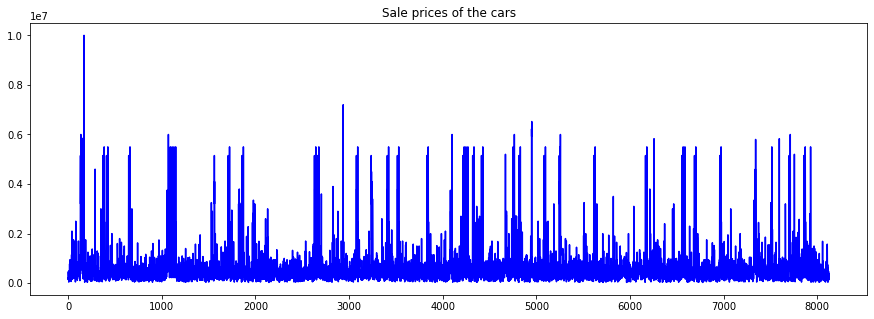

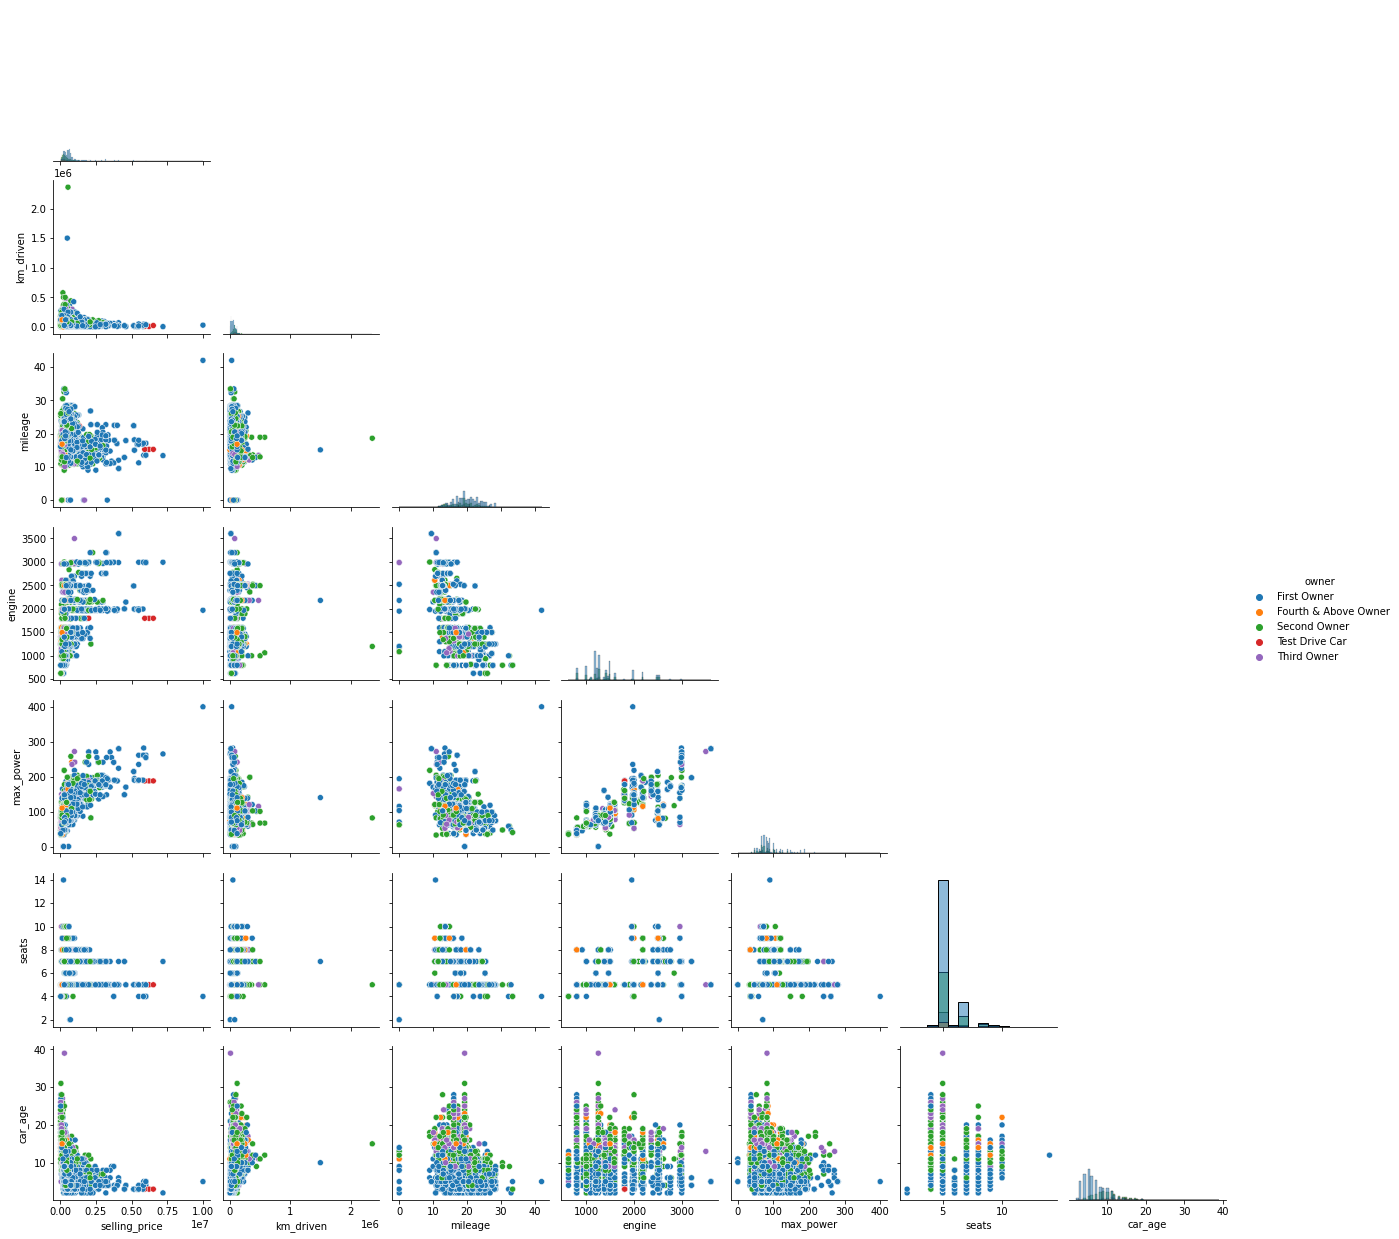

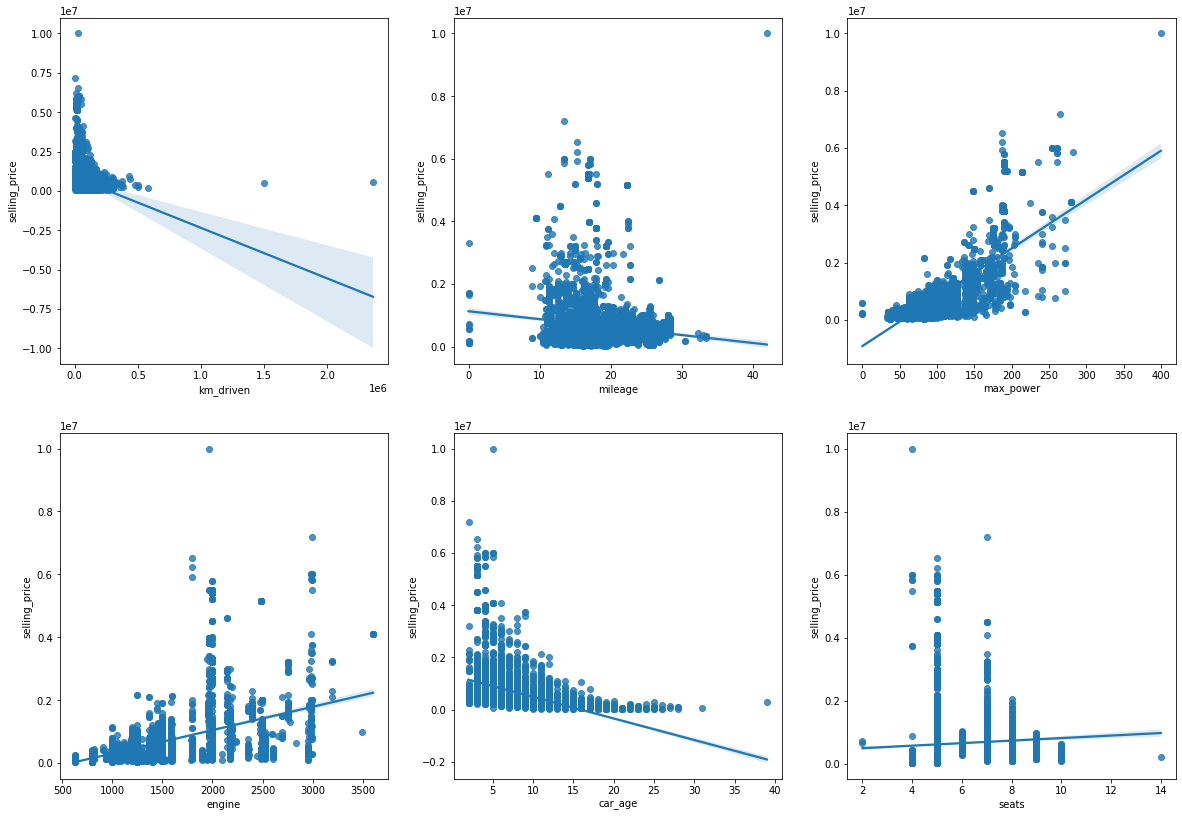

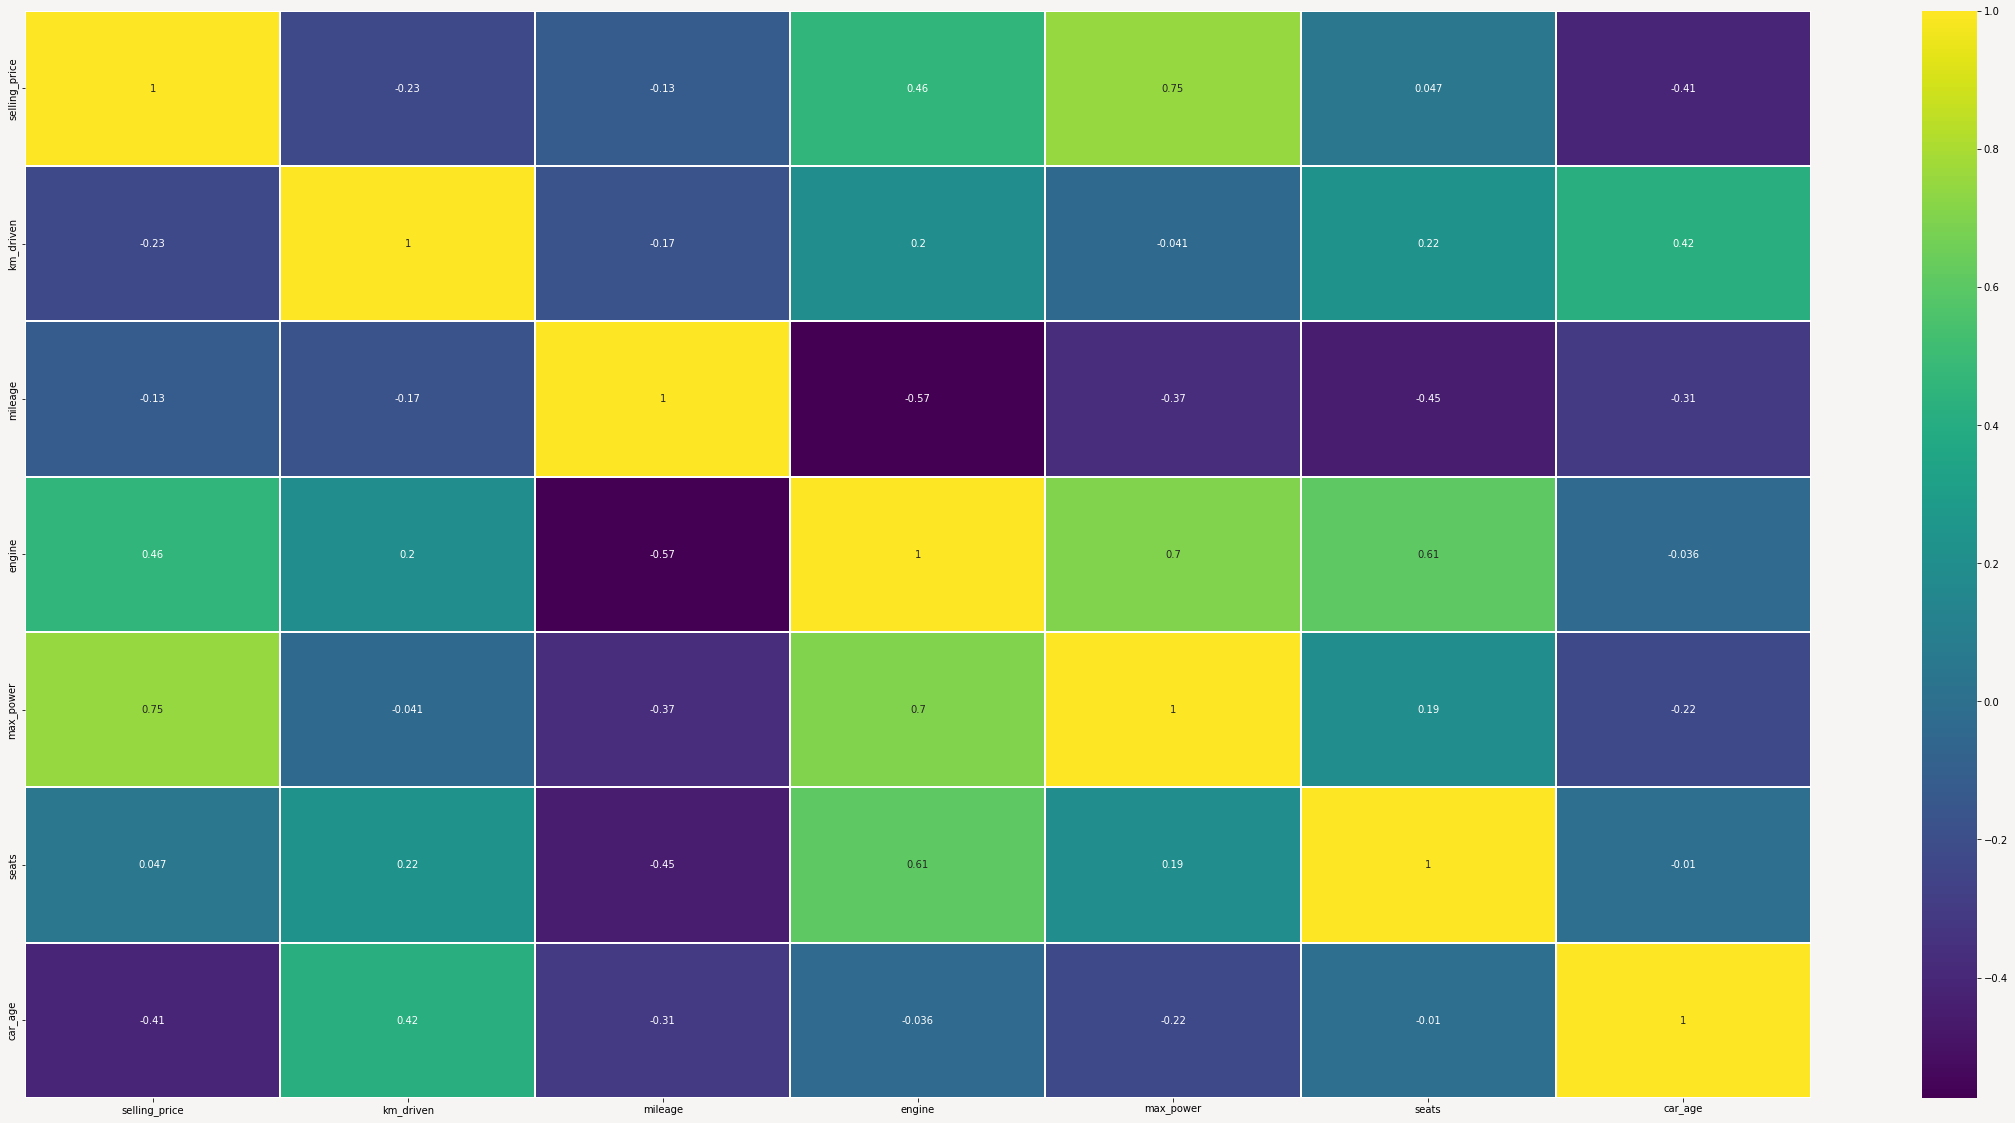

In [26]:
fig = px.histogram(df, x = "car_age",
                   y = "selling_price",
                   marginal = None, text_auto = True,
                   color = "owner", hover_data  = df.columns, width = 850, height = 500)
fig.show()
fig = px.histogram(df, x = "engine",
                   y = "km_driven",
                   marginal = None, text_auto = True,
                   color = "fuel", hover_data  = df.columns, width = 850, height = 500)
fig.show()
fig = px.histogram(df, x = "car_age",
                   y = "km_driven",
                   marginal = None, text_auto = True,
                   color = "owner", hover_data  = df.columns, width = 850, height = 500)
fig.show()
fig = px.density_heatmap(df, x = "max_power", y = "selling_price", z = "mileage",
                        color_continuous_scale = "deep", text_auto = True,
                        title = "Density heatmap between variables")
fig.show()
fig = px.density_heatmap(df, x = "seats", y = "engine", z = "max_power", color_continuous_scale = "portland",
                         text_auto = True, title = "Density heatmap between variables")
fig.show()
fig, ax = plt.subplots(figsize = (15, 5))
sale_price = list()
for sp in df["selling_price"].values:
    sale_price.append(sp)
sale_price = pd.Series(sale_price)
sale_price.plot(kind = "line", colormap = "winter").set_title("Sale prices of the cars");

sns.pairplot(df, hue = "owner", diag_kind = "hist", corner = True);

fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = df);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = df);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = df);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = df);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = df);
sns.regplot(ax = axes[5], x = "seats", y = "selling_price", data = df);

plt.figure(figsize = [40, 20], facecolor = "#F7F4F4")
sns.heatmap(df.corr(), annot = True, linewidths = 2, linecolor = "white", cmap = "viridis");

df.corr().style.background_gradient(cmap = "binary")

In [28]:
print("Basic descriptive statistics of the target variable - 'selling_price': \n\n",
      df["selling_price"].describe())

Basic descriptive statistics of the target variable - 'selling_price': 

 count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+05
75%      6.750000e+05
max      1.000000e+07
Name: selling_price, dtype: float64


In [30]:
print("Skewness of target variable: ", df["selling_price"].skew())
print("Kurtosis of target variable: ", df["selling_price"].kurt())

Skewness of target variable:  4.193533440675855
Kurtosis of target variable:  21.081289012186755


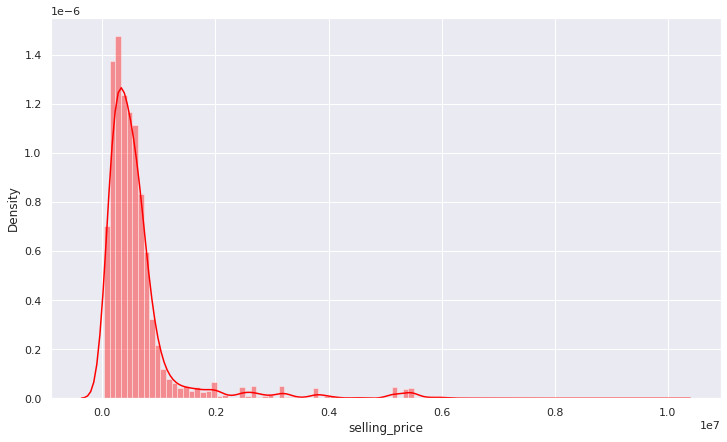

In [31]:
sns.set(rc = {"figure.figsize" : (12, 7)})
sns.distplot(df["selling_price"], bins = 100, color = "red");

In [32]:
df["selling_price"] = np.log1p(df["selling_price"])
df["selling_price"].head(n = 10)

0    13.017005
1    12.821261
2    11.970357
3    12.323860
4    11.775297
5    12.994532
6    11.472114
7    10.714440
8    12.765691
9    12.206078
Name: selling_price, dtype: float64

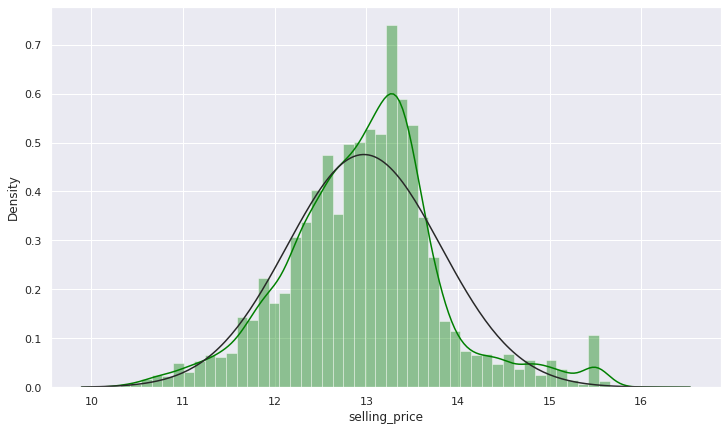

In [33]:
sns.distplot(df["selling_price"], fit = norm, color = "green");

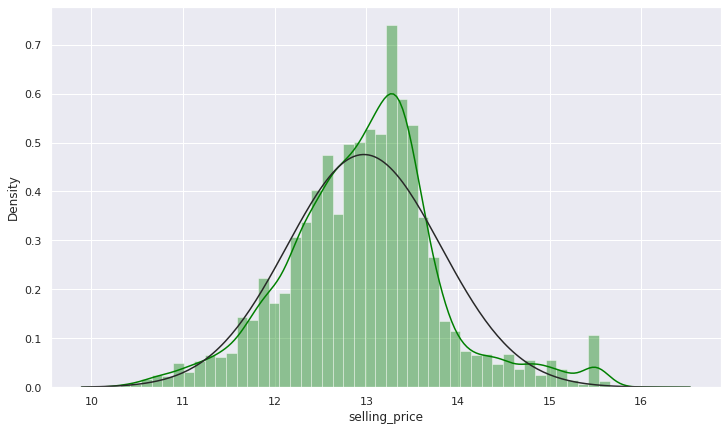

In [34]:
sns.distplot(df["selling_price"], fit = norm, color = "green");

In [35]:
for c in numeric_data:
    df[c] = np.log1p(df[c])

In [36]:
df.head().style.background_gradient(cmap = "plasma")

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,2.640271,11.887938,Diesel,Individual,Manual,First Owner,3.194583,7.130099,4.317488,1.791759,Maruti,2.197225
1,2.626208,11.695255,Diesel,Individual,Manual,Second Owner,3.097386,7.312553,4.649378,1.791759,Skoda,2.197225
2,2.562666,11.849405,Petrol,Individual,Manual,Third Owner,2.928524,7.311886,4.369448,1.791759,Honda,2.833213
3,2.589556,11.751950,Diesel,Individual,Manual,First Owner,3.178054,7.242082,4.510860,1.791759,Hyundai,2.564949
4,2.547513,11.695255,Petrol,Individual,Manual,First Owner,2.839078,7.169350,4.490881,1.791759,Maruti,2.772589


In [38]:
y = df["selling_price"]
x = df.drop("selling_price", axis = 1)
x = pd.get_dummies(x, drop_first = True)

In [40]:
y.shape, x.shape

((8128,), (8128, 47))

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 1)
print(x_train.shape)
print(x_test.shape)

(6502, 47)
(1626, 47)


In [42]:
rob_scaler = RobustScaler()
rob_scaler.fit(x_train)
x_train = rob_scaler.transform(x_train)
x_test = rob_scaler.transform(x_test)

In [43]:
k_fold = KFold(n_splits = 10, random_state = 11, shuffle = True)
def cv_rmse(model, X = x_train):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

def rmsle(y, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y, y_pred, squared = False))
    return rmsle

In [44]:
xgb = XGBRegressor(n_estimators = 1000, random_state = 1)
lgbm = LGBMRegressor(n_estimators = 1000, random_state = 1)
gbr = GradientBoostingRegressor(n_estimators = 1000, random_state = 11)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
svr = SVR(C = 20)
lasso = LassoCV(alphas = [1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4,
                                                        5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1,
                                                        0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30,
                                                        45, 50, 70, 90], n_jobs = -1, cv = k_fold)

stacked = StackingCVRegressor(regressors = (xgb, lgbm, svr, lasso, gbr, rf),
                              meta_regressor = xgb, use_features_in_secondary = True)

stacked_model = stacked.fit(np.array(x_train), np.array(y_train))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6649354378785487, tolerance: 0.0017079911037838713
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7945203151230122, tolerance: 0.0017079911037838713
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9486995112033679, tolerance: 0.0017079911037838713
  positive,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

In [45]:
stacked_score_train = rmsle(y_train, stacked_model.predict(x_train))
print("RMSLE score of stacked models on full train data:", stacked_score_train)

RMSLE score of stacked models on full train data: 0.055277231224877266


In [46]:
stacked_score_test = rmsle(y_test, stacked_model.predict(x_test))
print("RMSLE score of stacked models on full test data:", stacked_score_test)

RMSLE score of stacked models on full test data: 0.06742701774666494


In [47]:
y_pred = np.expm1(stacked_model.predict(x_test))
y_pred[0:5]

array([12.148244, 14.057808, 13.595757, 13.049793, 12.378493],
      dtype=float32)

In [48]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared: {}'.format(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error: 10.304625379678567
Mean Squared Error: 106.73322900625702
Root Mean Squared Error: 10.331177522734619
R-squared: -31415.394607815062


Text(0, 0.5, 'prediction')

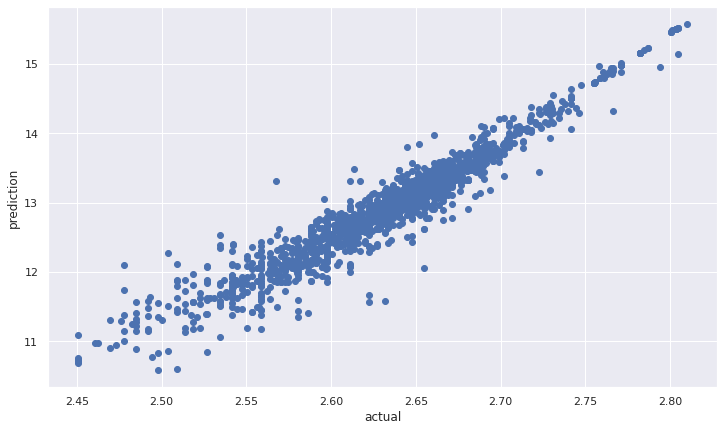

In [49]:
plt.scatter(y_test, y_pred);
plt.xlabel("actual")
plt.ylabel("prediction")